# Sex Classification using Periocular and Iris Images

---

*Note on the nomenclature in this project:*

*The word "sex" will be used throughout this project in place of the often incorrectly used "gender". Gender refers to characteristics assigned by cultural norms while sex are biological and physiologic characteristics.*

Need to think on this a bit more... If the model is picking up on certain periocular characteristics (applied makeup), an argument can be made for the use of the word gender here.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

import tensorflow as tf
import torch
from torchvision.transforms import ToTensor
from facenet_pytorch import MTCNN, InceptionResnetV1
from sklearn.decomposition import PCA



import sklearn
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, KFold, train_test_split

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def image_import(file_list, sex):
    '''
    Takes a list of image filenames and loads the images into a dictionary with the same filename(*).

    (*) Adds up to 4 leading zeros to the name if they are not present.
    
    Parameters:
        file_list: List of filenames in the form ['name.extension', ...]
        sex: String denoting the folder in ./data to find the images. ('Male' or 'Female')
    Returns:
        eyes_dict: Dictionary whose keys are the filename with leading zeros and value is a numpy array of the image.
    '''
    eyes_dict = {}
    for file in file_list:
        # Separate file extension and name.
        number, _ = file.split('.')
        number_new = number.zfill(4) # Add leading zeros.
        # Only take odd numbers to remove more than 1 eye per person.
        if int(number) % 2 == 1:
            img = Image.open(f'./data/{sex}/{number}.jpg')
            # Used to check resizing
            # if np.asarray(img).flatten().shape[0] > (160*160*3):
            #     print(number_new, np.asarray(img).shape)
            img = img.resize((160,160), Image.Resampling.LANCZOS)
            eyes_dict[number_new] = np.asarray(img).flatten()

    return eyes_dict

In [3]:
female_files = os.listdir('./data/Female')
male_files = os.listdir('./data/male')

eyes_female = image_import(female_files, 'Female')
eyes_male = image_import(male_files, 'Male')

print('Number of Females:', len(eyes_female))
print('Number of Males:', len(eyes_male))

Number of Females: 2591
Number of Males: 3173


(160, 160, 3)


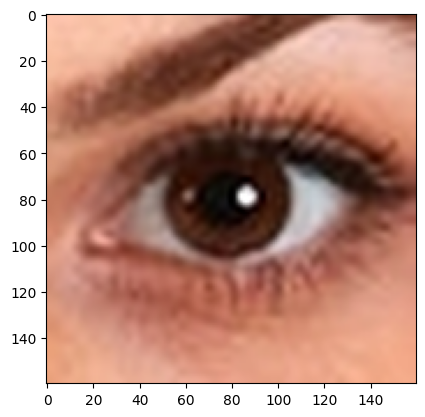

In [4]:
print(eyes_female['0011'].reshape(160,160,3).shape)
plt.imshow(Image.fromarray(eyes_female['0011'].reshape(160,160,3)))
plt.show()

The shape of `(160, 160, 3)` indicates an 3-dimensional array representing RGB with no alpha channel.

In [5]:
eyes_female_df = pd.DataFrame(eyes_female.items(), columns = ['eye_d', 'rgb_array'])
eyes_male_df = pd.DataFrame(eyes_male.items(), columns = ['eye_d', 'rgb_array'])

eyes_female_df['sex'] = 0
eyes_male_df['sex'] = 1

In [6]:
# Balance classes, limiting the number of male eyes.
eyes_male_df = eyes_male_df.sample(n = len(eyes_female_df), random_state = 11, replace = False)

# Create dataframe with mixed sexes.
eyes_df = pd.concat([eyes_female_df, eyes_male_df]).reset_index(drop = True)
eyes_df

eye_d                                          rgb_array  sex
0     0823  [217, 171, 137, 217, 171, 137, 217, 171, 135, ...    0
1     4217  [141, 77, 49, 141, 77, 49, 142, 77, 49, 142, 7...    0
2     5109  [238, 210, 194, 241, 212, 196, 243, 214, 198, ...    0
3     4571  [237, 210, 193, 237, 210, 193, 236, 209, 192, ...    0
4     1409  [175, 143, 130, 175, 143, 130, 174, 143, 129, ...    0
...    ...                                                ...  ...
5177  0579  [151, 112, 105, 151, 112, 105, 150, 111, 104, ...    1
5178  5191  [209, 209, 209, 210, 210, 210, 211, 211, 211, ...    1
5179  0425  [163, 118, 87, 163, 118, 87, 163, 118, 87, 164...    1
5180  5491  [74, 52, 55, 69, 47, 50, 62, 40, 42, 52, 30, 3...    1
5181  0821  [221, 159, 138, 221, 159, 138, 221, 160, 138, ...    1

[5182 rows x 3 columns]

Split 
- Train = 70%
- Validation = 18%
- Test = 12%

In [7]:
X_train, X_test = train_test_split(eyes_df, test_size = 0.12, shuffle = True, stratify = eyes_df.sex, random_state = 11)

# Create validation set.
val_size = int(0.18 * len(X_train))
X_val = X_train.iloc[-val_size: ]
X_train = X_train.iloc[: -val_size]

# Create y.
y_train = X_train.sex
y_val = X_val.sex
y_test = X_test.sex

# Drop y from X.
X_train = X_train.drop(columns = ['sex'])
X_val = X_val.drop(columns = ['sex'])
X_test = X_test.drop(columns = ['sex'])

print(f'Train Set Size: {len(X_train)}')
print(f'Validation Set Size: {len(X_val)}')
print(f'Test Set Size: {len(X_test)}')

Train Set Size: 3740
Validation Set Size: 820
Test Set Size: 622


Normalize

In [8]:
X_train['norm_array'] = X_train['rgb_array'] / 255
X_val['norm_array'] = X_val['rgb_array'] / 255
X_test['norm_array'] = X_test['rgb_array'] / 255

Grayscale

In [9]:
def convert_to_grayscale(df):
    # Uses same method as PIL.
    # https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.convert
    rgb_array_reshape = df.rgb_array.reshape(160,160,3)
    gray_array = np.dot(rgb_array_reshape, [0.2990, 0.5870, 0.1140])
    #gray_array_3_channel = np.concatenate((gray_array,)*3, axis = -1)
    return (gray_array.flatten())

# Convert all images and add grayscale arrays to dataframe.
X_train['gray_array'] = X_train.apply(convert_to_grayscale, axis = 1)

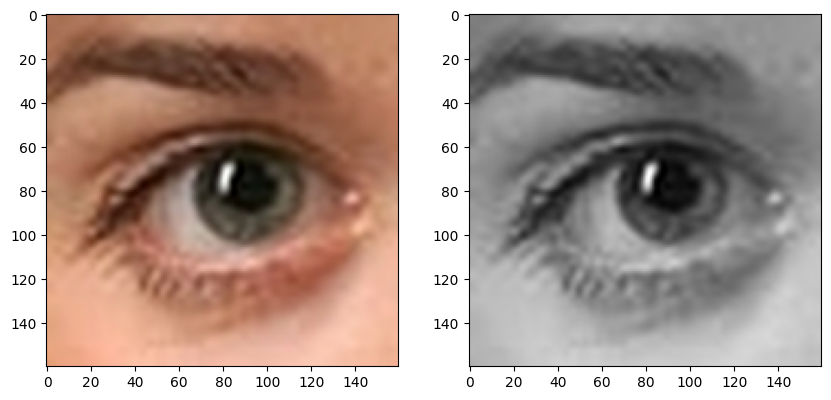

In [10]:
fig, ax = plt.subplots(1, 2, figsize = (10,6))
ax[0].imshow(Image.fromarray(X_train.iloc[250].rgb_array.reshape(160,160,3)))
ax[1].imshow(Image.fromarray(X_train.iloc[250].gray_array.reshape(160,160)))
plt.show()

Develop texture maps and feature extractor filters

Check Week 2 Lecture 9 notes from DL/CV 5707 (Verma, Zisserman, A Statistical Approach to Texture Classification from Single Images)

Develop Image Transformation Function that works for training and testing.

(Random intensity, horizontal and vertical mirroring, rotations, subset crop of image + padding, etc)

Shallow Tensorflow sequential model.

In [11]:
model = tf.keras.Sequential()

model.add(tf.keras.Input(shape = (76800, ), name = 'Flattened Image'))
model.add(tf.keras.layers.Dense(512, activation = tf.keras.activations.relu))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(128, activation = tf.keras.activations.relu))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(2, name = 'Predictions'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │    39,322,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Predictions (Dense)             │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,388,034 (150.25 MB)

 Trainable params: 39,388,034 (150.25 MB)

 Non-trainable params: 0 (0.00 B)

Model Specifications:

- Loss Function: Sparse Categorical using Cross-Entropy
- Optimizer: Adam
- Callbacks:
    - Early Stopping
    - Adjust Learning Rate on Loss Plateau

In [12]:
loss_fx = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True) # Integer labels.
optimizer_param = 'adam'
val_freq = 1
n_epochs = 100
# Callbacks to use:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 20, verbose = 1, restore_best_weights = True)
reduce_lr_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 5, min_lr = 0.0001, verbose = 1)

model.compile(optimizer = optimizer_param, loss = loss_fx, metrics = ['accuracy'])

mod_tf_seq = model.fit(
    x = np.stack(X_train.norm_array.to_numpy()),
    y = y_train.to_numpy(),
    batch_size = None,
    epochs = n_epochs,
    verbose = "auto",
    callbacks = [early_stop, reduce_lr_plateau],
    validation_split = 0.0,
    validation_data = (np.stack(X_val.norm_array.to_numpy()), y_val.to_numpy()),
    shuffle = True,
    class_weight = None,
    sample_weight = None,
    initial_epoch = 0,
    steps_per_epoch = None,
    validation_steps = None,
    validation_batch_size = None,
    validation_freq = val_freq)

Epoch 1/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 17s 142ms/step - accuracy: 0.5375 - loss: 12.2297 - val_accuracy: 0.7463 - val_loss: 0.5259 - learning_rate: 0.0010
Epoch 2/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 16s 138ms/step - accuracy: 0.6493 - loss: 0.8439 - val_accuracy: 0.7744 - val_loss: 0.4851 - learning_rate: 0.0010
Epoch 3/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 17s 142ms/step - accuracy: 0.6947 - loss: 0.6489 - val_accuracy: 0.7585 - val_loss: 0.5070 - learning_rate: 0.0010
Epoch 4/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 16s 140ms/step - accuracy: 0.7086 - loss: 0.5933 - val_accuracy: 0.6037 - val_loss: 0.6992 - learning_rate: 0.0010
Epoch 5/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 17s 142ms/step - accuracy: 0.7351 - loss: 0.5786 - val_accuracy: 0.6159 - val_loss: 0.8296 - learning_rate: 0.0010
Epoch 6/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 0.5269 - loss: 0.7173 - val_accuracy: 0.5280 - val_loss: 0.6911 - learning_rate: 0.0010
Epoch 7/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accura

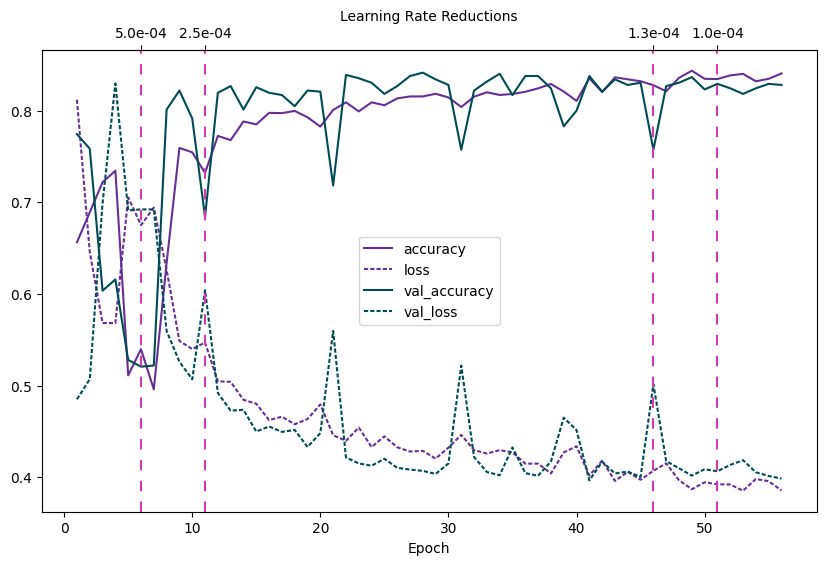

In [94]:
# Create dataframe of model fit history.
mod_tf_seq_df = pd.DataFrame().from_dict(mod_tf_seq.history, orient = 'columns')
mod_tf_seq_df.head()
# Find all epochs that callback ReduceLROnPlateau() occurred.
lr_change = mod_tf_seq_df.learning_rate.shift(-1) != mod_tf_seq_df.learning_rate

# Create colormap for train/val
set_cmap = {'accuracy': '#653096',
            'loss': '#653096',
            'val_accuracy': '#004a54',
            'val_loss': '#004a54'}
set_dashmap = {'accuracy': '',
            'loss': (2,1),
            'val_accuracy': '',
            'val_loss': (2,1)}

# Plot
fig, ax = plt.subplots(figsize = (10,6))
ax = sns.lineplot(mod_tf_seq_df.drop(columns = ['learning_rate']).iloc[1:], palette = set_cmap, dashes = set_dashmap)
ax.set_xlabel('Epoch')
# Create secondary x-axis for Learning Rate changes.
sec_ax = ax.secondary_xaxis('top')
sec_ax.set_xticks(mod_tf_seq_df[lr_change].index[:-1])
sec_ax.set_xticklabels([f'{x:.1e}' for x in mod_tf_seq_df[lr_change].learning_rate[1:]])
sec_ax.set_xlabel('Learning Rate Reductions')
# Create vertical line for each LR change.
for epoch in (mod_tf_seq_df[lr_change].index[:-1]):
    plt.axvline(x = epoch, c = '#d439ad', ls = (0, (5,5)))
plt.show()

In [13]:
y_pred_tf_seq_proba = model.predict(np.stack(X_test.norm_array.to_numpy()), batch_size=None, verbose="auto", steps=None, callbacks=None)
y_pred_tf_seq = y_pred_tf_seq_proba.argmax(axis = 1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [14]:
# model.evaluate(
#     x=np.stack(X_test.norm_array.to_numpy()),
#     y=y_test.to_numpy(),
#     batch_size=None,
#     verbose="auto",
#     sample_weight=None,
#     steps=None,
#     callbacks=None,
#     return_dict=False
#     )

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8669 - loss: 0.3621


[0.3689882457256317, 0.8633440732955933]

In [1]:
sum(y_pred_tf_seq == y_test) / len(y_test)

NameError: name 'y_pred_tf_seq' is not defined

Deep Learning Model

Extract deep learning embedding for PCA plot. Proof of concept with a pretrained face model.

To be continued.. Project has changed a bit since this was done -- will come back to this later when I build a DL CNN model.

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Running on device: {device}')

resnet = InceptionResnetV1(pretrained = 'vggface2', device = device).eval()

Running on device: cpu


In [17]:
embeddings_female = []
with torch.no_grad():
    for eye in X_train[y_train == 0].rgb_array.to_list():
        eye_tensor = ToTensor()(Image.fromarray(eye.reshape(160,160,3))).to(device).unsqueeze(0)
        embedding = resnet(eye_tensor).squeeze().cpu().tolist()
        embeddings_female.append(embedding)

embeddings_male = []
with torch.no_grad():
    for eye in X_train[y_train == 1].rgb_array.to_list():
        eye_tensor = ToTensor()(Image.fromarray(eye.reshape(160,160,3))).to(device).unsqueeze(0)
        embedding = resnet(eye_tensor).squeeze().cpu().tolist()
        embeddings_male.append(embedding)

embeddings = embeddings_female + embeddings_male
X_train['embedding'] = embeddings
X_train

# embeddings_female = []
# with torch.no_grad():
#     for eye in eyes_female.values():
#         eye_tensor = ToTensor()(Image.fromarray(eye.reshape(160,160,3))).to(device).unsqueeze(0)
#         embedding = resnet(eye_tensor).squeeze().cpu().tolist()
#         embeddings_female.append(embedding)

# embeddings_male = []
# with torch.no_grad():
#     for eye in eyes_male.values():
#         eye_tensor = ToTensor()(Image.fromarray(eye.reshape(160,160,3))).to(device).unsqueeze(0)
#         embedding = resnet(eye_tensor).squeeze().cpu().tolist()
#         embeddings_male.append(embedding)

# embeddings = embeddings_female + embeddings_male
# eyes_df['embedding'] = embeddings
# eyes_df

KeyboardInterrupt: 

Visualize the resulting embeddings.

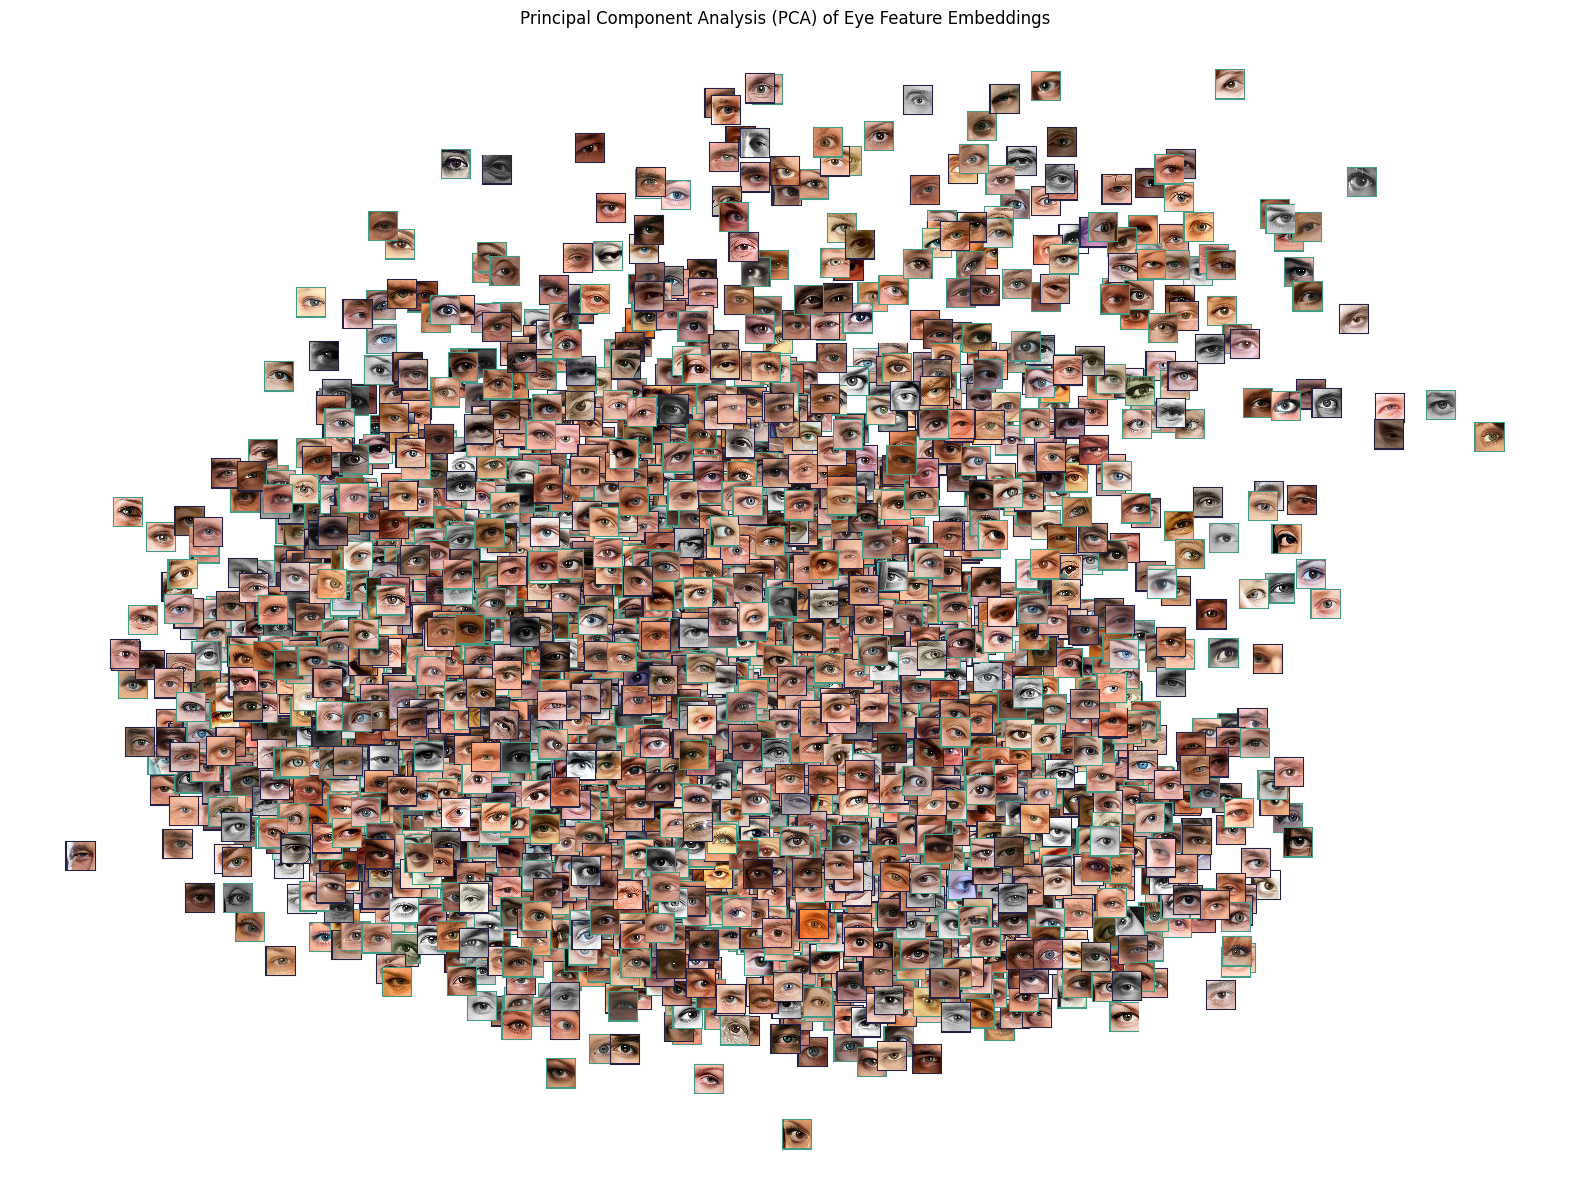

In [ ]:
def pca_plot(features, image_arrays, zoom = 0.125, cmap = None, photos = True):

    # Reduce dimensions to 2 using PCA.
    pca_fit = PCA(n_components = 2).fit_transform(features)

    _, ax = plt.subplots(figsize = (20, 15), subplot_kw = {'aspect' : 'equal'})
    ax.scatter(pca_fit[:, 0], pca_fit[:, 1], c = cmap_sex, alpha = 0.8)
    
    # Add eye photos to plot.
    if photos == True:
        for i, rgb_array in enumerate(image_arrays):
            # Load image.
            image = Image.fromarray(rgb_array.reshape(160,160,3))
            # Zoom out.
            im = OffsetImage(image, zoom = zoom)
            # Set class label color for edge bbox.
            bboxprops = ({'edgecolor' : cmap[i], 'lw' : 1.5} if cmap is not None else None)
            anno_bbox = AnnotationBbox(offsetbox = im, 
                                xy = pca_fit[i],
                                xycoords = 'data',
                                frameon = (bboxprops is not None),
                                pad = 0.015,
                                bboxprops = bboxprops)
            ax.add_artist(anno_bbox)

    ax.set_axis_off()
    ax.axis('tight')
    ax.set_title('Principal Component Analysis (PCA) of Eye Feature Embeddings')

    return ax

# Teal = Women, Purple = Men
# cmap_sex = ['#439A86' if sex == 0 else '#242244' for sex in eyes_df.sex]
cmap_sex = ['#439A86' if sex == 0 else '#242244' for sex in y_train]

_ = pca_plot(X_train.embedding.tolist(), X_train.rgb_array.tolist(), cmap = cmap_sex)
plt.show()

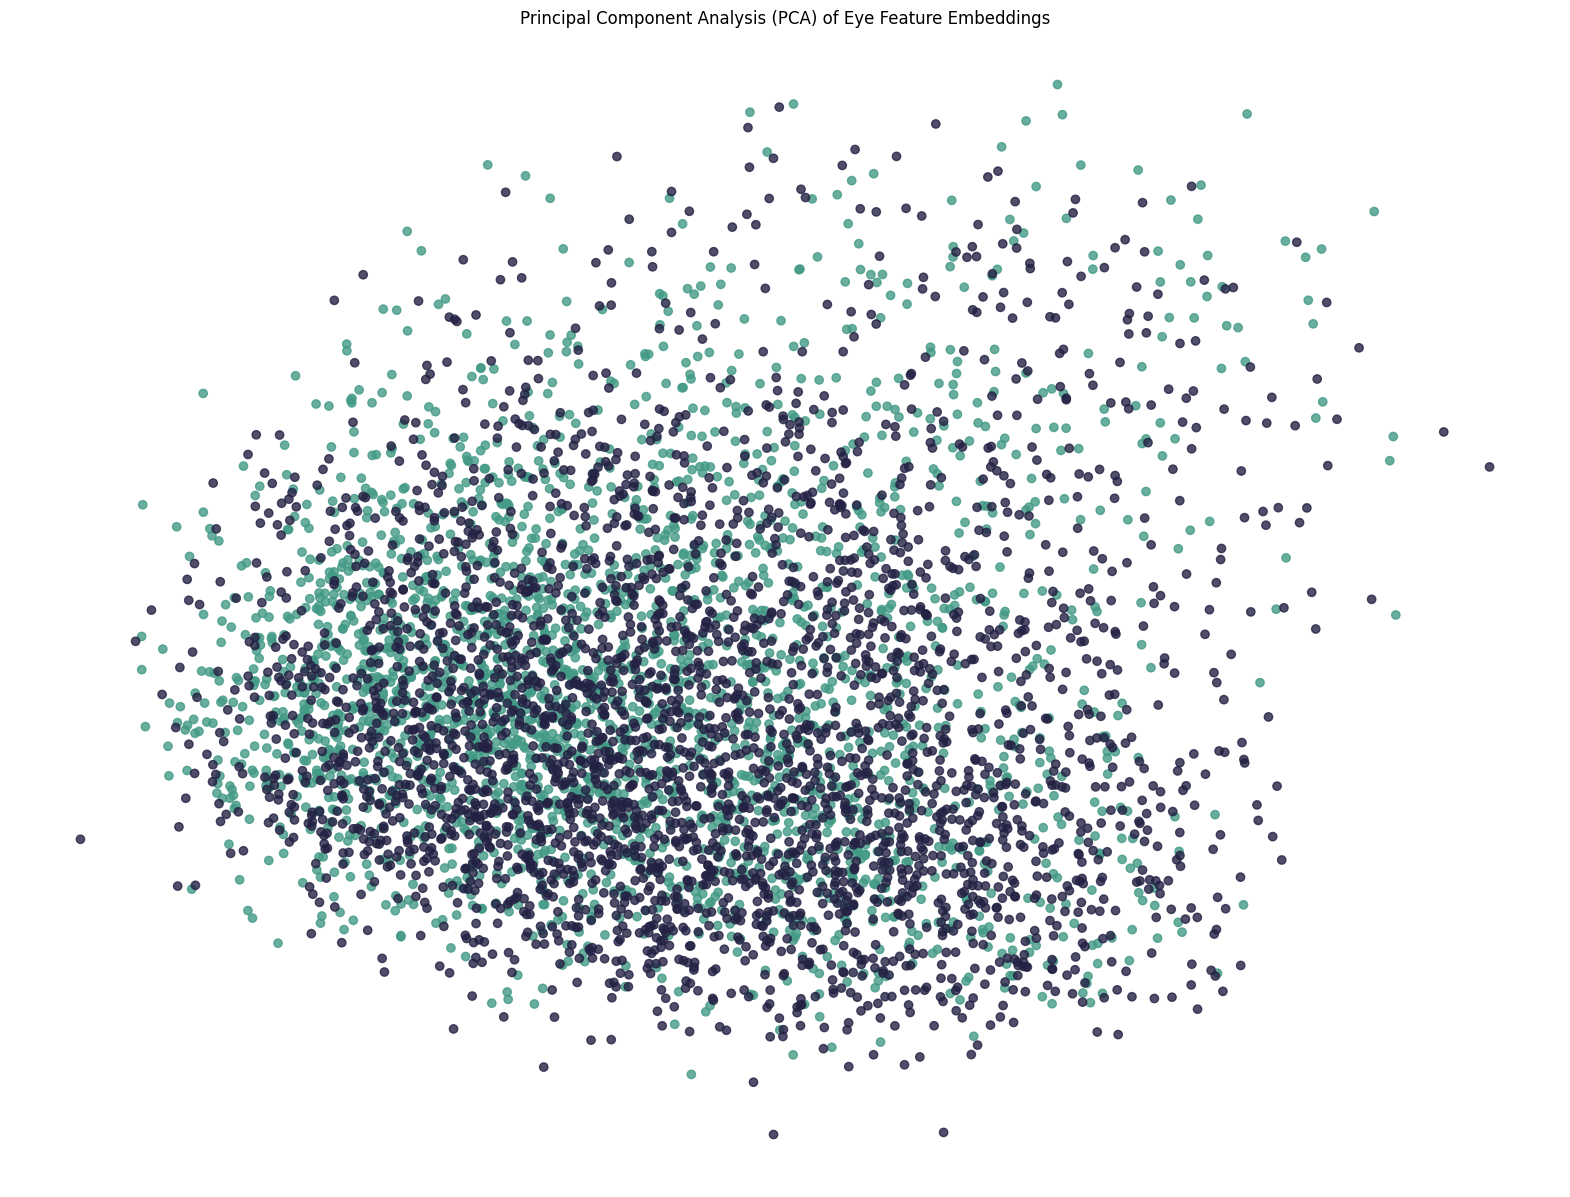

In [ ]:
_ = pca_plot(eyes_df.embedding.tolist(), eyes_df.rgb_array.tolist(), cmap = cmap_sex, photos = False)
plt.show()

## Appendix A - Online References: <a name="appendixa"></a>

Resources that helped along the way in no particular order.

1. 2016 paper iris sex classification based on in-depth feature selection and SVM: https://ieeexplore.ieee.org/abstract/document/7447785
2. 2018 paper iris sex classification based on Zernike moments and classifying using SVM and KNN: https://ieeexplore.ieee.org/document/8492757
3. 2019 paper iris .. using CNNs and image augmentation: https://ieeexplore.ieee.org/abstract/document/7447785
4. 2023 paper classifcation using periocular region and iris using pre-trained CNNs and transfer learning: https://www.sciencedirect.com/science/article/pii/S2666307423000268
5. 2019 Paper refuting previous papers claims on classifications based solely on iris; claiming periocular features were included: https://ieeexplore.ieee.org/document/8659186
6. Great examples of utilizing matplotlib to plot PCA/t-SNE tied to their images https://www.kaggle.com/code/hmendonca/proper-clustering-with-facenet-embeddings-eda
7. Local Binary Patterns used for feature extraction: https://en.wikipedia.org/wiki/Local_binary_patterns
8. Sobel filter edge detector: https://en.wikipedia.org/wiki/Sobel_operator

Alternative Datasets that would improve this project and allow for more nuanced segmentation of eye features:
1. Biometrics Research of Notre Dame has a high quality dataset. Behind a license application: https://cvrl.nd.edu/projects/data/
2. Another dataset with high-resolution iris photos. Behind license and too big for this project, though: https://ieee-dataport.org/documents/iris-super-resolution-dataset